### Linear Regression - Interpreting the result
In this notebook we use linear regression to predict the coefficients corresponding to the top eigenvectors of the measurements:
* TAVG: The average temperature for day/location. (TMAX + TMIN)/2
* TRANGE: The temperature range between the highest and lowest temperatures of the day. TMAX-TMIN.
* SNWD: The depth of the accumulated snow.

These 9 variables are the output variables that we aim to predict.

The 4 input variables we use for the regression are properties of the location of the station:
* latitude, longitude: location of the station.
* elevation: the elevation of the location above sea level.
* dist_coast: the distance of the station from the coast (in kilometers).

### Read and parse the data

In [3]:
%cd /Users/Deepthi/Documents/DSE/Q3_DSE230 - Data analysis using Spark/Day 3/Assignment/Data

/Users/Deepthi/Documents/DSE/Q3_DSE230 - Data analysis using Spark/Day 3/Assignment/Data


In [4]:
import pickle
import pandas as pd
!ls *.pickle  # check 

users-partition.pickle


In [19]:
!curl -o "stations_projections.pickle" "http://mas-dse-open.s3.amazonaws.com/Weather/stations_projections.pickle"

# !curl -o STAT_TAVG_RANGE.pickle http://mas-dse-open.s3.amazonaws.com/Weather/STAT_TAVG_RANGE.pickle

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2750k  100 2750k    0     0   254k      0  0:00:10  0:00:10 --:--:--  321k


In [21]:
data = pickle.load(open("stations_projections.pickle",'r'))
data.shape

# data = pickle.load(open("STAT_TAVG_RANGE.pickle",'r'))
# data.shape

(12140, 8)

In [22]:
data.head(1)

,station,TAVG_coeff,TRANGE_coeff,SNWD_coeff,latitude,longitude,elevation,dist_coast
0,USC00044534,"[3047.96236332, 1974.34852034, 150.560792408]","[-2903.63287861, -236.907267527, 147.021790682]","[0.19150300062, 0.187262808215, -0.0401379552536]",36.0042,-119.96,73.2,107.655


In [23]:
# break up the lists of coefficients separate columns
for col in [u'TAVG_coeff', u'TRANGE_coeff', u'SNWD_coeff']:
    for i in range(3):
        new_col=col+str(i+1)
        data[new_col]=[e[i] for e in list(data[col])]
    data.drop(labels=col,axis=1,inplace=True)
data.drop(labels='station',axis=1,inplace=True)
data.head(1)

,latitude,longitude,elevation,dist_coast,TAVG_coeff1,TAVG_coeff2,TAVG_coeff3,TRANGE_coeff1,TRANGE_coeff2,TRANGE_coeff3,SNWD_coeff1,SNWD_coeff2,SNWD_coeff3
0,36.0042,-119.96,73.2,107.655,3047.962363,1974.34852,150.560792,-2903.632879,-236.907268,147.021791,0.191503,0.187263,-0.040138


### Performing and evaluating the regression
As the size of the data is modest, we can perform the regression using regular python (not spark) running on a laptop. We use the library `sklearn`

In [24]:
from sklearn.linear_model import LinearRegression

### Coefficient of determination

Computed by calling the method `LinearRegression.score()`

The regression score comes under several names: "Coefficient of determination", $R^2$, "R squared score", "percentage of variance explained", "correlation coefficient". It is explained in more detail in [wikipedia](https://en.wikipedia.org/wiki/Coefficient_of_determination).

Roughly speaking the $R^2$-score measures the fraction of the variance of the regression output variable that is explained by the prediction function. The score varies between 0 and 1. A score of 1 means that the regression function perfectly predicts the value of $y$. A score of 0 means that it does not predict $y$ at all.

#### Training score vs Test score
Suppose we fit a regression function with 10 features to 10 data points. We are very likely to fit the data perfectly and get a score of 1. However, this does not mean that our model truly explains the data. It just means that the number of training examples we are using to fit the model is too small. To detect this situation, we can compute the score of the model that was fit to the **training set**, on a **test set**. If the ratio between the test score and the training score is smaller than, say, 0.1, then our regression function probably over-fits the data.

#### Finding the importance of input variables
The fact that a regression coefficient is far from zero provides some indication that it is important. However, the size of these coefficients also depends on the scaling of the variables. A much more reliable way to find out which of the input variables are important is to compare the score of the regression function we get when using all of the input variables to the score when one of the variables is eliminated. This is sometimes called "sensitivity analysis"

In [28]:
# Compute score changes
def compute_scores(y_label,X_Train,y_Train,X_test,Y_test):
    lg = LinearRegression()
    lg.fit(X_Train,y_Train)

    train_score = lg.score(X_Train,y_Train)
    test_score = lg.score(X_test,Y_test)
    print('R-squared(Coeff. of determination): Train:%.3f, Test:%.3f\n' % (train_score,test_score))

    full=set(range(X_Train.shape[1]))
    for i in range(X_Train.shape[1]):
        L=list(full.difference(set([i])))  # fill in
        L.sort()
        r_train_X=X_Train[:,L]
        r_test_X=X_test[:,L]
        
        lg = LinearRegression()
        lg.fit(r_train_X,y_Train)
        r_train_score = lg.score(r_train_X,y_Train)
        r_test_score  = lg.score(r_test_X,Y_test)
        print "removed",data.columns[i],
        print "Score decrease: \tTrain:%5.3f" % (train_score-r_train_score),
        print "\tTest: %5.3f " % (test_score-r_test_score)

### Partition into training set and test set
By dividing the data into two parts, we can detect when our model over-fits. When over-fitting happens, the significance on the test set is much smaller than the significance on the training set.

In [31]:
from numpy.random import rand
N=data.shape[0]
train_i = rand(N)>0.5
Train = data.ix[train_i,:]
Test  = data.ix[~train_i,:]   # fill in
print data.shape,Train.shape,Test.shape

(12140, 13) (6046, 13) (6094, 13)


In [32]:
from sklearn.cross_validation import train_test_split

train_X = Train.ix[:,:4].values
test_X=Test.ix[:,:4].values
input_names=list(data.columns[:4])

for target in ["TAVG","TRANGE","SNWD"]:
    for j in range(1,4):
        y_label = target+"_coeff"+str(j)
        train_y = Train[y_label]
        test_y = Test[y_label]
        lg = LinearRegression()
        lg.fit(train_X,train_y)

        print "\nTarget variable: ", y_label, '#'*40
        print "Coeffs: ",\
            ' '.join(['%s:%5.2f ' % (input_names[i],lg.coef_[i]) for i in range(len(lg.coef_))])
        
        compute_scores(y_label, train_X, train_y, test_X, test_y)


Target variable:  TAVG_coeff1 ########################################
Coeffs:  latitude:-155.36  longitude:-19.69  elevation:-0.68  dist_coast:-0.14 
R-squared(Coeff. of determination): Train:0.931, Test:0.931

removed latitude Score decrease: 	Train:0.614 	Test: 0.611 
removed longitude Score decrease: 	Train:0.069 	Test: 0.064 
removed elevation Score decrease: 	Train:0.126 	Test: 0.123 
removed dist_coast Score decrease: 	Train:0.003 	Test: 0.003 

Target variable:  TAVG_coeff2 ########################################
Coeffs:  latitude:-4.38  longitude: 7.10  elevation:-0.15  dist_coast: 0.47 
R-squared(Coeff. of determination): Train:0.591, Test:0.596

removed latitude Score decrease: 	Train:0.006 	Test: 0.008 
removed longitude Score decrease: 	Train:0.107 	Test: 0.124 
removed elevation Score decrease: 	Train:0.076 	Test: 0.059 
removed dist_coast Score decrease: 	Train:0.389 	Test: 0.383 

Target variable:  TAVG_coeff3 ########################################
Coeffs:  latitude

### Interpretation
When we find a statistically significant coefficient, we want to find a rational explanation for the significance and for the sign of the corresponding coefficient. Please write a one line explanation for each of the following nine input/output pairs (the ones that are numbered).

```
Target variable:  TAVG_coeff1 ########################################
Coeffs:  latitude:-153.98  longitude:-19.21  elevation:-0.68  dist_coast:-0.13 
R-squared(Coeff. of determination): Train:0.931, Test:0.931

1. removed latitude Score decrease: 	Train:0.613 	Test: 0.612 
2. removed elevation Score decrease: 	Train:0.128 	Test: 0.121 

Target variable:  TAVG_coeff2 ########################################
Coeffs:  latitude:-5.33  longitude: 7.46  elevation:-0.14  dist_coast: 0.48 
R-squared(Coeff. of determination): Train:0.603, Test:0.585

3. removed longitude Score decrease: 	Train:0.115 	Test: 0.116 
4. removed dist_coast Score decrease: 	Train:0.393 	Test: 0.378 

Target variable:  TAVG_coeff3 ########################################
Coeffs:  latitude:-4.19  longitude:-2.64  elevation: 0.01  dist_coast: 0.07 
R-squared(Coeff. of determination): Train:0.420, Test:0.398

5. removed longitude Score decrease: 	Train:0.148 	Test: 0.164 
6. removed dist_coast Score decrease: 	Train:0.095 	Test: 0.082 

Target variable:  TRANGE_coeff1 ########################################
Coeffs:  latitude:25.00  longitude: 8.63  elevation:-0.36  dist_coast:-0.15 
R-squared(Coeff. of determination): Train:0.478, Test:0.435

7. removed elevation Score decrease: 	Train:0.127 	Test: 0.113 

Target variable:  TRANGE_coeff2 ########################################
Coeffs:  latitude:-32.63  longitude: 6.04  elevation:-0.02  dist_coast: 0.14 
R-squared(Coeff. of determination): Train:0.649, Test:0.642

8. removed latitude Score decrease: 	Train:0.461 	Test: 0.454 

Target variable:  SNWD_coeff1 ########################################
Coeffs:  latitude:147.72  longitude:21.54  elevation: 1.09  dist_coast:-0.88 
R-squared(Coeff. of determination): Train:0.232, Test:0.238

9. removed latitude Score decrease: 	Train:0.153 	Test: 0.155 
```

### Write your answers here

Consult the plots of the eigen-vectors. `SNWD` is available in an earlier notebook.
The statistics for TRANGE and TAVG is in the file
`http://mas-dse-open.s3.amazonaws.com/Weather/STAT_TAVG_RANGE.pickle`

For each of the following eigen-vectors, give a short verbal description

1. TAVG_coeff1: average temperature across the year
2. TAVG_coeff2: Difference in temperature between summer and winter
3. TAVG_coeff3: Unable to interpret   
4. TRANGE_coeff1: Average daily temperature range across the year
5. TRANGE_coeff2: Difference in daily temperature range between summer and winter
6. SNWD_coeff1: Average snow depth across the year


Once you have given a meaning to each of these eigen-vectors, explain the relation to the input variable. Short explanations are better than long ones.

Example:

1. Locations with high latitude are colder.
2. Increased elevation decreases the temperature.
3. The stations in the east coast (higher longitude) have more pronounced difference in average temperature between seasons when compared to those in the west coast (lower longitude).
4. Difference between average temperature in Summer and Winter is influenced by the distance from the coast. The farther away from the coast you are, the more difference in average temperature.
5. Unable to interpret
6. Unable to interpret
7. Lower elevations have higher daily temperature ranges.
8. Larger daily temperature ranges when you are closer to the equator.
9. Increased snow depth with increase in latitude.

In [34]:
!curl -o STAT_TAVG_RANGE.pickle http://mas-dse-open.s3.amazonaws.com/Weather/STAT_TAVG_RANGE.pickle

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.6M  100 25.6M    0     0  1729k      0  0:00:15  0:00:15 --:--:--  974k


In [35]:
data2 = pickle.load(open("STAT_TAVG_RANGE.pickle",'r'))

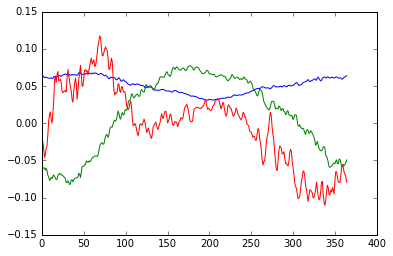

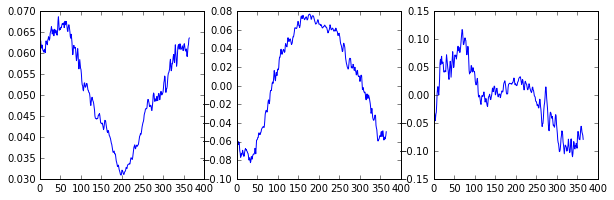

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot first three eigen vectors together
plt.plot(data2[0].get('TAVG')['eigvec'][:,0:3])
plt.show()

# Plot TAVG first three eigen vectors
    
plt.figure(1,figsize = (10,3))
plt.subplot(131)
plt.plot(data2[0].get('TAVG')['eigvec'][:,0:1])

plt.subplot(132)
plt.plot(data2[0].get('TAVG')['eigvec'][:,1:2])

plt.subplot(133)
plt.plot(data2[0].get('TAVG')['eigvec'][:,2:3])

plt.show()

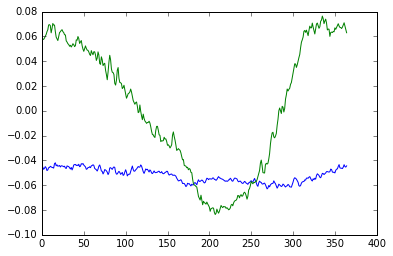

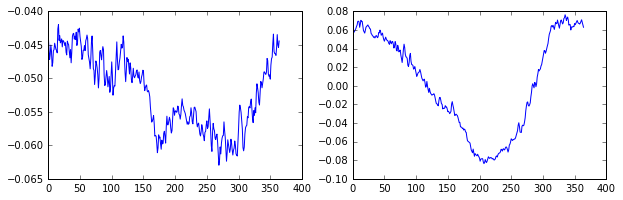

In [85]:
# Plot first three eigen vectors together
plt.plot(data2[0].get('TRANGE')['eigvec'][:,0:2])
plt.show()

# Plot TAVG first three eigen vectors
    
plt.figure(1,figsize = (10,3))
plt.subplot(121)
plt.plot(data2[0].get('TRANGE')['eigvec'][:,0:1])

plt.subplot(122)
plt.plot(data2[0].get('TRANGE')['eigvec'][:,1:2])

plt.show()